In [3]:
import pandas as pd

inflows = pd.read_parquet('/uss/hdsi-prismdata/q1-ucsd-inflows.pqt')
outflows = pd.read_parquet('/uss/hdsi-prismdata/q1-ucsd-outflows.pqt')

In [8]:
import re
import pandas as pd
from collections import Counter

# Global counter to track removed items
removed_counter = Counter()

# Common junk words or tokens to remove
JUNK_WORDS = {
    # system / channel tokens
    "CHECKCARD","DEBIT","CREDIT","WITHDRAWAL","PURCHASE","PAYMENT","AUTH","POS","ATM",
    "AUTHORIZED","SELF_TRANSFER","EXTERNAL_TRANSFER","RECURRING","ACCOUNTFEES","CREDITCARDPAYMENT",
    "REF","TXN","TRXN","BILL","CARD","PAYMENTAUTH","POINT","OF","SALE",
    # web-ish
    "WWW","COM","ORG","NET","HTTP","HTTPS",
    # common short junk and state codes 
    "CRD","PUR"
}

def clean_memo(text):
    """Cleans transaction memo strings and counts removed patterns."""
    global removed_counter

    if pd.isna(text):
        return ""
    
    s = str(text)

    # Normalize separators
    s = s.replace("*", " ").replace("/", " ").replace("\\", " ").replace("-", " ").replace(".", " ")
    
    # Uppercase all the charactors
    s = s.upper()

    # --- Track and Remove System Keywords ---
    sys_keywords = re.findall(
        r'\b(?:CHECKCARD|DEBIT|CREDIT|WITHDRAWAL|PURCHASE|PAYMENT|AUTH|POS|ATM|SELF_TRANSFER|EXTERNAL_TRANSFER|RECURRING|AUTHORIZED|ACCOUNTFEES|CREDITCARDPAYMENT|REF|TXN|TRXN)\b',
        s, flags=re.IGNORECASE)
    removed_counter.update([kw.lower() for kw in sys_keywords])
    s = re.sub(
        r'\b(?:CHECKCARD|DEBIT|CREDIT|WITHDRAWAL|PURCHASE|PAYMENT|AUTH|POS|ATM|SELF_TRANSFER|EXTERNAL_TRANSFER|RECURRING|AUTHORIZED|ACCOUNTFEES|CREDITCARDPAYMENT|REF|TXN|TRXN)\b',
        ' ', s, flags=re.IGNORECASE)

    # --- Track & Remove Visa/Check phrases ---
    visa_patterns = re.findall(r'\b(?:visa|mastercard|check\s*card|visa\s*check|visa\s*debit)\b', s, flags=re.IGNORECASE)
    removed_counter.update([kw.lower() for kw in visa_patterns])
    s = re.sub(r'\b(?:visa|mastercard|check\s*card|visa\s*check|visa\s*debit)\b', ' ', s, flags=re.IGNORECASE)

    # --- Track & Remove VSA PMT patterns ---
    vsa_patterns = re.findall(r'\b(?:vsa\s*pmt|vsa|pmt)\b', s, flags=re.IGNORECASE)
    removed_counter.update([kw.lower() for kw in vsa_patterns])
    s = re.sub(r'\b(?:vsa\s*pmt|vsa|pmt)\b', ' ', s, flags=re.IGNORECASE)

    # --- Track & Remove https/www tokens ---
    https_tokens = re.findall(r'\bhttps?www\w*\b', s, flags=re.IGNORECASE)
    removed_counter.update(["httpswww" for _ in https_tokens])
    s = re.sub(r'\bhttps?www\w*\b', ' ', s, flags=re.IGNORECASE)

    # --- Track & Remove xxx patterns ---
    xxx_count = len(re.findall(r'\w*x{2,}\w*', s, flags=re.IGNORECASE))
    removed_counter["xxx_patterns"] += xxx_count
    s = re.sub(r'\w*x{2,}\w*', ' ', s, flags=re.IGNORECASE)

    # --- Track & Remove mixed alphanumeric tokens ---
    mixed_count = len(re.findall(r'\b(?=\w*[A-Za-z])(?=\w*\d)\w+\b', s))
    removed_counter["mixed_alphanum"] += mixed_count
    s = re.sub(r'\b(?=\w*[A-Za-z])(?=\w*\d)\w+\b', ' ', s)

    # --- Track & Remove numeric data (dates, codes, etc.) ---
    num_count = len(re.findall(r'\b\d+\b', s))
    removed_counter["numbers"] += num_count
    s = re.sub(r'\b\d{2}/\d{2}\b', ' ', s)
    s = re.sub(r'\b\d{4}\b', ' ', s)
    s = re.sub(r'\b\d+\b', ' ', s)
    
    # --- Track & Remove states ---
    states = r"\b(?:AL|AK|AZ|AR|CA|CO|CT|DE|FL|GA|HI|ID|IL|IN|IA|KS|KY|LA|ME|MD|MA|MI|MN|MS|MO|" \
             r"MT|NE|NV|NH|NJ|NM|NY|NC|ND|OH|OK|OR|PA|RI|SC|SD|TN|TX|UT|VT|VA|WA|WV|WI|WY|DC)\b"
    state_matches = re.findall(states, s, flags=re.IGNORECASE)
    removed_counter["states"] += len(state_matches)
    s = re.sub(states, " ", s, flags=re.IGNORECASE)
    
    # --- Standardize common brand and abbreviation variants ---
    abbr_patterns = [
        # more specific before general
        (r"\bUBER\s*EATS\b",          "UBER EATS"),
        (r"\bUBER\b",                 "UBER"),
        (r"\bAMZN\b",                 "AMAZON"),
        (r"\bMKTPL?\b",               "MARKETPLACE"),
        (r"\bMKTPLACE\b",             "MARKETPLACE"),
        (r"\bSQ\s*\*\s*",             "SQUARE "),
        (r"\bWAL[\s-]*MART\b",        "WALMART"),
        (r"\bWM\b",                   "WALMART"),
        (r"\bMCDONALD'?S?\b",         "MCDONALDS"),
        (r"\bSTBX\b",                 "STARBUCKS"),
        (r"\bTGT\b",                  "TARGET"),
        (r"\bCOSTCO\s+WHOLESALE\b",   "COSTCO"),
        (r"\bGOOG(L)?E?\b",           "GOOGLE"),
        (r"\bVENM(O)?\b",             "VENMO"),
        (r"\bZELLEPAY\b",             "ZELLE"),
    ]
    abbr_count = 0
    for pattern, repl in abbr_patterns:
        s, n = re.subn(pattern, repl, s, flags=re.IGNORECASE)
        abbr_count += n
    
    removed_counter["abbreviation"] = removed_counter.get("abbreviation", 0) + abbr_count

    # --- Remove punctuation & normalize ---
    s = re.sub(r'[^A-Za-z\s]', ' ', s)
    s = re.sub(r'\s{2,}', ' ', s).strip()

    # --- Token filtering ---
    tokens = []
    for t in s.split():
        if t in JUNK_WORDS:
            removed_counter["junk_words"] += 1
            continue
        tokens.append(t)

    return " ".join(tokens)





In [9]:
removed_counter.clear()  # Reset counter

outflows['memo_clean'] = outflows['memo'].apply(clean_memo)


In [10]:
outflows[['memo', 'memo_clean']].sample(50)

,memo,memo_clean
480099,AUTOMOTIVE,AUTOMOTIVE
2043421,POKEMOTO GALLAT XXXX GALLATIN,POKEMOTO GALLAT GALLATIN
504689,ENTERTAINMENT,ENTERTAINMENT
1317830,AUTOMOTIVE,AUTOMOTIVE
87455,TAX,TAX
218346,SELF_TRANSFER,
1245383,AUTOMOTIVE,AUTOMOTIVE
161297,Point Of Sale Withdrawal LIQUOR EXPO,LIQUOR EXPO
705867,ATM_CASH,CASH
1484746,EXTERNAL_TRANSFER,


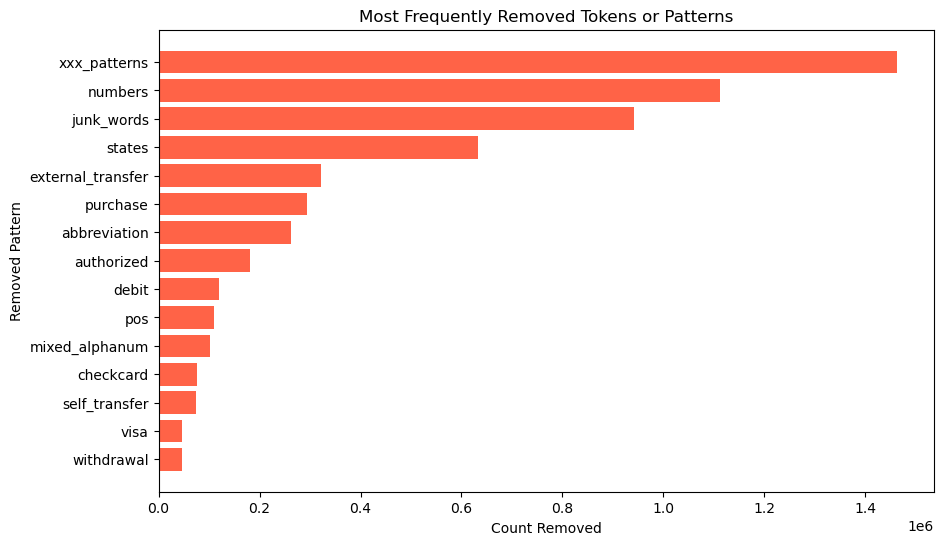

In [11]:
import matplotlib.pyplot as plt

removed_df = pd.DataFrame(removed_counter.most_common(), columns=["pattern_removed", "count"])

plt.figure(figsize=(10,6))
plt.barh(removed_df.head(15)["pattern_removed"], removed_df.head(15)["count"], color="tomato")
plt.gca().invert_yaxis()
plt.title("Most Frequently Removed Tokens or Patterns")
plt.xlabel("Count Removed")
plt.ylabel("Removed Pattern")
plt.show()


In [9]:

outflows.loc[224163, ['memo', 'memo_clean']]


memo          CHECKCARD XXXX WNYC WQXR NJPR NYPR RAD XXX-XXX...
memo_clean                              wnyc wqxr njpr nypr rad
Name: 224163, dtype: object